In [4]:
import pandas as pd
from Cohort import CohortTable

In [5]:
n_years = 3 # Over how long is the ramp up period
forecast_period = 6 # Length of period over which to forecast
hires_per_year = [1,2,2,3,4,6]
annual_attrition = .16 # Or, stated differently, we expect a given cohort to turn over every 7 years
revenue_goal = 1000000 # Can be single value or list, where length of list must equal forecast_period

myTable = CohortTable(forecast_period, n_years, hires_per_year, revenue_goal, annual_attrition=annual_attrition, first_year_full_hire=True)
myTable.print_all_tables()

,0,1,2,3,4,5
Cohort,,,,,,
0,0.2,0.3,0.4,0.2,0.0,0.0
1,0.0,0.0,0.6,0.9,0.4,0.0
2,0.0,0.0,0.0,0.6,0.9,0.4
3,0.0,0.0,0.0,0.0,1.0,1.3
4,0.0,0.0,0.0,0.0,0.0,1.3
5,0.0,0.0,0.0,0.0,0.0,0.0
Sum of FTE,0.2,0.3,1.1,1.7,2.2,3.0


,0,1,2,3,4,5
Cohort,,,,,,
0,1,1,1,1,0,0
1,0,2,2,1,1,0
2,0,0,2,2,1,1
3,0,0,0,3,2,2
4,0,0,0,0,4,3
5,0,0,0,0,0,6
Sum of Employees,1,3,5,7,8,12


,0,1,2,3,4,5
Cohort,,,,,,
0,"173,333","321,067","439,104","189,361",0,0
1,0,"13,333","642,133","878,208","378,721",0
2,0,0,"13,333","642,133","878,208","378,721"
3,0,0,0,"20,000","963,200","1,317,312"
4,0,0,0,0,"26,667","1,284,267"
5,0,0,0,0,0,"40,000"
Sum of Revenue,"173,333","334,400","1,094,571","1,729,702","2,246,796","3,020,300"


In [4]:
# Function to shrink or extend list to specific lenth
def size_list(l, length, pad=0):
    if len(l) >= length:
        del l[length:]
    else:
        l.extend([pad] * (length - len(l)))

In [5]:
# Ensure hire_per_year list matches forecast_period
size_list(hires_per_year, forecast_period)

# Create productivity matrix by cohort and year using nested list comprehension
productivity_list = [[min(max(n, 0)/n_years, 1) for n in range(1-i, forecast_period+1-i)] for i in range(forecast_period)]
productivity_df = pd.DataFrame(productivity_list)

# Apply hiring plan to productivity matrix to derive FTE count by cohort and year
fte_df = productivity_df.multiply(hires_per_year, axis=0)

# Apply mid-point hiring to FTE DF to account for initial year (assumes hiring throughout, not at beginning of period)
midpoint_mask = np.ones(shape = (forecast_period, forecast_period))
np.fill_diagonal(midpoint_mask, .5)
midpoint_mask_df = pd.DataFrame(midpoint_mask)
fte_df = fte_df.multiply(midpoint_mask_df)

# Translate FTE to actual number of employees
employee_count_df = fte_df.apply(np.ceil)

# Calculate expected attrition by year and derive retained employees by cohort and year
attrition_df = employee_count_df.multiply(annual_attrition, axis=0).cumsum(axis=1).apply(np.floor)
retained_employee_count_df = employee_count_df.subtract(attrition_df)
fte_retained_df = fte_df.subtract(attrition_df)

# Calculate revenue by cohort and year using retained FTE
revenue_df = fte_retained_df.multiply(revenue_goal)

In [6]:
# Display Various Tables
fte_retained_df.index.name='Cohort'

# FTE
fte_retained_df.loc['Sum of FTE'] = fte_retained_df.sum()
fte_retained_df_styled = fte_retained_df.style.set_caption('FTE (Based on Productivity Ramp Up) by Year')
display(fte_retained_df_styled)

# Employees by Year
retained_employee_count_df.loc['Sum of Employees'] = retained_employee_count_df.sum()
retained_employee_count_df_styled = retained_employee_count_df.style.format('{:.0f}').set_caption('Employees by Year, After Attrition')
display(retained_employee_count_df_styled)

# Revenue by Year
revenue_df.loc['Sum of Revenue'] = revenue_df.sum()
revenue_df_styled = revenue_df.style.format('{:,.0f}').set_caption('Revenue by Year')
display(revenue_df_styled)

,0,1,2,3,4,5,6,7,8,9
Cohort,,,,,,,,,,
0,0.166667,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.000000,0.333333,1.333333,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000
2,0.000000,0.000000,0.333333,1.333333,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
3,0.000000,0.000000,0.000000,0.500000,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000
4,0.000000,0.000000,0.000000,0.000000,0.666667,2.666667,4.000000,3.000000,3.000000,2.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,5.000000,5.000000,4.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.333333,5.333333,7.000000,6.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,7.000000,10.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,0,1,2,3,4,5,6,7,8,9
Cohort,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,0
1,0,1,2,2,2,2,1,1,1,1
2,0,0,1,2,2,2,2,1,1,1
3,0,0,0,1,2,3,3,2,2,2
4,0,0,0,0,1,3,4,3,3,2
5,0,0,0,0,0,1,4,5,5,4
6,0,0,0,0,0,0,2,6,7,6
7,0,0,0,0,0,0,0,2,7,10
8,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9
Cohort,,,,,,,,,,
0,167,667,"1,000","1,000","1,000","1,000","1,000","1,000","1,000",0
1,0,333,"1,333","2,000","2,000","2,000","1,000","1,000","1,000","1,000"
2,0,0,333,"1,333","2,000","2,000","2,000","1,000","1,000","1,000"
3,0,0,0,500,"2,000","3,000","3,000","2,000","2,000","2,000"
4,0,0,0,0,667,"2,667","4,000","3,000","3,000","2,000"
5,0,0,0,0,0,"1,000","4,000","5,000","5,000","4,000"
6,0,0,0,0,0,0,"1,333","5,333","7,000","6,000"
7,0,0,0,0,0,0,0,"2,000","7,000","10,000"
8,0,0,0,0,0,0,0,0,0,0


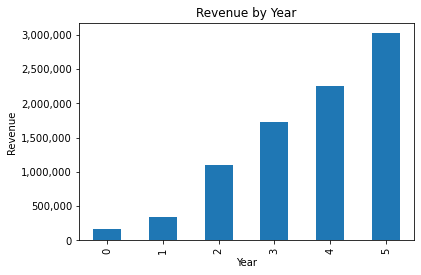

In [44]:
ax = myTable.revenue_df.loc['Sum of Revenue'].plot(kind='bar', title='Revenue by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Revenue')
ax.yaxis.set_major_formatter(FuncFormatter('{0:,.0f}'.format))

In [52]:
myTable.revenue_df.to_excel('Revenue Table.xlsx', sheet_name='Revenue')